# 1) Function Definitions

In [519]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm

X1_LB = 0.05
X1_UB = 2
X2_LB = 0.25
X2_UB = 1.3
X3_LB = 2
X3_UB = 15

MAX_F_CALLS = 3000

np.random.seed(1999)


def f(x1, x2, x3):
    return x1**2 * x2 * (2 + x3)

def g1(x1, x2, x3):
    return 1 - (x2**3 * x3) / (71785 * x1**4)

def g2(x1, x2, *x3):
    return (4 * x2**2 - x1 * x2) / (12566 * (x2 * x1**3 - x1**4)) + 1 / (5108 * x1**2) - 1

def g3(x1, x2, x3):
    return 1 - (140.45 * x1) / (x2**2 * x3)

def g4(x1, x2, *x3):
    return (x1 + x2) / 1.5 - 1
    calls = reset_calls(funcs)
        
CONSTRAINTS=[g1, g2, g3, g4]
        
# Get a grid of x*y*z points. shape = (entries, variables) so it's easy to apply
# 3-dimensional functions over the matrices in numpy-style
def get_points(x1_samples, x2_samples, x3_samples):
    # take samples between ranges
    x1 = np.linspace(X1_LB, X1_UB, x1_samples)
    x2 = np.linspace(X2_LB, X2_UB, x2_samples)
    x3 = np.linspace(X3_LB, X3_UB, x3_samples)
    # get all combinations
    points = np.array(np.meshgrid(x1, x2, x3)).T.reshape(-1, 3)
    return points

# Given a matrix of x*y*z points where shape = (entries, variables),
# return a mask where mask[i] is whether the point is valid or not
def get_valid_mask(points, constraints=[g1, g2, g3, g4]):
    points = np.swapaxes(points, 0, 1)
    running_mask = None
    # compute the mask for each constraint in turn,
    # ANDing with what we already have
    for constraint in constraints:
        mask = constraint(*points) <= 0
        if running_mask is not None:
            running_mask = np.logical_and(running_mask, mask)
        else:
            running_mask = mask

    return running_mask

def get_costs(points):
    points = np.swapaxes(points, 0, 1)
    return f(*points)

# Grid Search

From a sample of 375000 points in feature space, 2730 (0.73%) are valid.
Applying f on these 2730 samples...
Best values (lowest output): f(x1=0.05391, x2=0.39483, x3=10.125) --> 0.01391.
Worst values (highest output): f(x1=0.13597, x2=1.3, x3=11.20833) --> 0.31746.


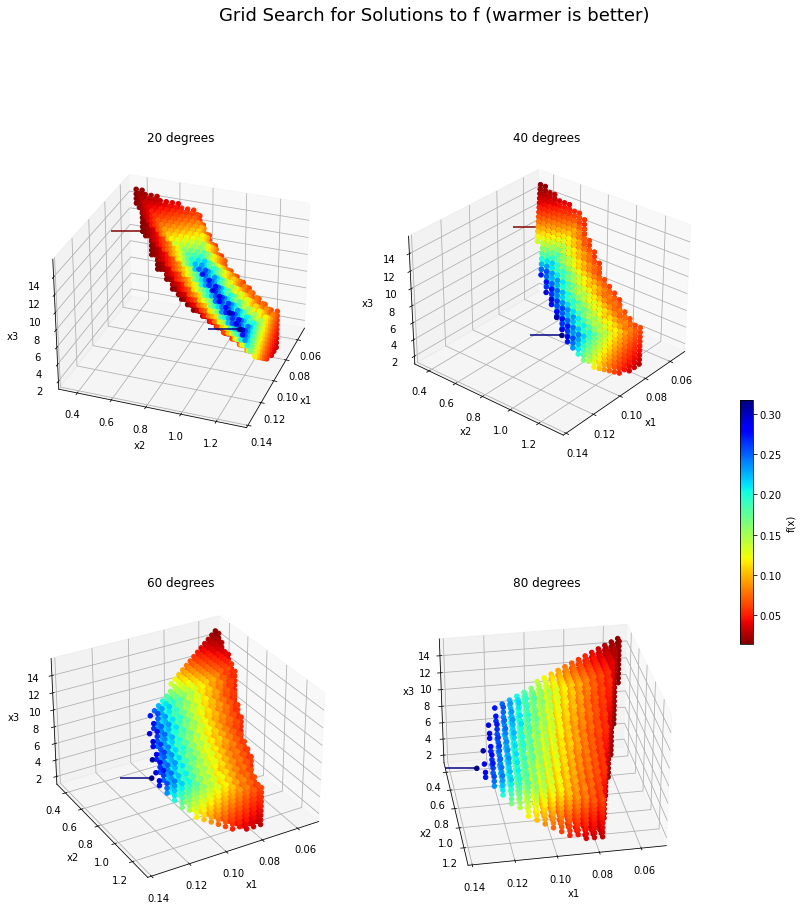

In [520]:
def get_best_worst(vld, results, rnd=5):
    worst_i = np.where(results==np.max(results))[0][0]
    best_i = np.where(results==np.min(results))[0][0]
    return (best_i, worst_i)

# plot the results
def vis(vld, results, best_i=None, worst_i=None, rotation_amount=40, reverse_cmap=False, title=None, alpha=1):
    print(f"Best values (lowest output): f(x1={round(vld[best_i, 0], rnd)}, x2={round(vld[best_i, 1], rnd)}, x3={round(vld[best_i, 2], rnd)}) --> {round(results[best_i], rnd)}.")
    print(f"Worst values (highest output): f(x1={round(vld[worst_i, 0], rnd)}, x2={round(vld[worst_i, 1], rnd)}, x3={round(vld[worst_i, 2], rnd)}) --> {round(results[worst_i], rnd)}.")
    fig = plt.figure(figsize=(15,15))
    cmap = cm.jet_r if reverse_cmap else cm.jet
    if title:
        fig.suptitle(title, fontsize=18)
    
    for i in range(1,5):
        ax = fig.add_subplot(2,2,i, projection="3d")
        s = ax.scatter(vld[:, 0], vld[:, 1], vld[:, 2], c=results, alpha=alpha, cmap=cmap)
        view_angle = i * rotation_amount
        ax.view_init(30, view_angle)
        # if the optional params for best and worst points were included, plot them as ticks.
        if not (best_i==None or worst_i==None):
            ax.scatter(vld[best_i, 0], vld[best_i, 1], vld[best_i, 2], marker=0, s=1000, color=cmap(0.0))
            ax.scatter(vld[worst_i, 0], vld[worst_i, 1], vld[worst_i, 2], marker=0, s=1000, color=cmap(1.0))
        ax.set_title(f"{view_angle} degrees")
        ax.set_xlabel("x1")
        ax.set_ylabel("x2")
        ax.set_zlabel("x3")
    cbar = fig.colorbar(s, ax=fig.axes, shrink=0.3)
    cbar.set_label("f(x)")
    
# These hyperparameters were picked by hand through trial and
# error to create a good visualisation of the solution space.
# This is why it performs better than random search
spc = get_points(500, 30, 25)
valid_mask = get_valid_mask(spc)
vld = spc[valid_mask]
results = get_costs(vld)
print(f"From a sample of {len(spc)} points in feature space, {len(vld)} ({round((len(vld) / len(spc)) * 100, 2) }%) are valid.")
print(f"Applying f on these {len(vld)} samples...")
best_i, worst_i = print_best_worst(vld, results)
vis(vld, results, best_i, worst_i, rotation_amount=20, title="Grid Search for Solutions to f (warmer is better)", reverse_cmap=True)    

# 2) Random Search

Applying f on these 3000 samples...
Best values (lowest output): f(x1=0.05373, x2=0.40226, x3=9.31165) --> 0.01314.
Worst values (highest output): f(x1=0.12887, x2=1.1134, x3=14.50942) --> 0.30529.


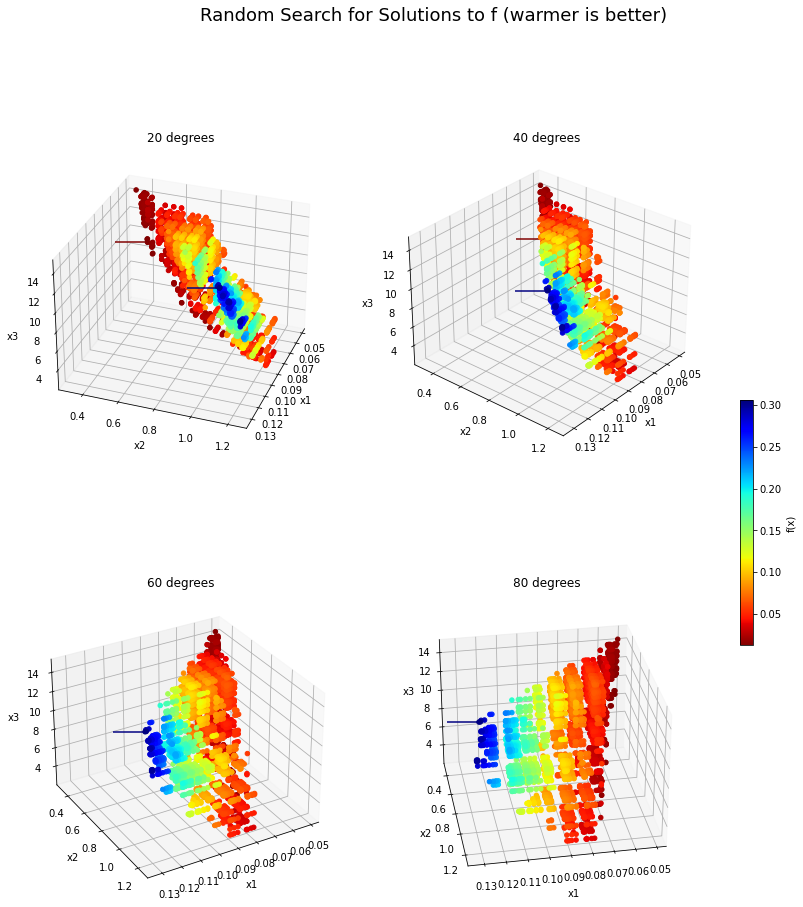

In [627]:
def get_random_points(x1_samples, x2_samples, x3_samples):
    x1 = np.random.uniform(X1_LB, X1_UB, x1_samples)
    x2 = np.random.uniform(X2_LB, X2_UB, x2_samples)
    x3 = np.random.uniform(X3_LB, X3_UB, x3_samples)
    # get all combinations
    points = np.array(np.meshgrid(x1, x2, x3)).T.reshape(-1, 3)
    return points

def random_search():
    points = get_random_points(1500, 20, 20)
    valid_mask = get_valid_mask(points)
    valid = points[valid_mask]
    rnd_idx = np.arange(min(MAX_F_CALLS, len(valid)))
    np.random.shuffle(rnd_idx)
    valid = valid[rnd_idx]
    print(f"Applying f on these {len(valid)} samples...")
    costs = get_costs(valid)
    best_i, worst_i = print_best_worst(valid, costs)

points = get_random_points(1500, 20, 20)
valid_mask = get_valid_mask(points)
valid = points[valid_mask]
rnd_idx = np.arange(min(MAX_F_CALLS, len(valid)))
np.random.shuffle(rnd_idx)
valid = valid[rnd_idx]
print(f"Applying f on these {len(valid)} samples...")
costs = get_costs(valid)
best_i, worst_i = print_best_worst(valid, costs)
vis(valid, costs, best_i, worst_i, rotation_amount=20, title="Random Search for Solutions to f (warmer is better)", reverse_cmap=True)

# 3) Genetic Algorithm
- Fitness Proportional Selection
- Static Penalty
- Blend Crossover
- Gaussian Mutation

In [628]:
from sklearn.preprocessing import minmax_scale
import heapq

class GeneticSimulation:  
    K_SURVIVORS = 12
    MUTATION_RATE = 0.05
    MUTATE_AMOUNT = 0.5
    CHILDREN_PER_COUPLE = 2
    CONSTRAINT_BETA = 1
    
    def __init__(self):
        #np.random.seed(42)
        self.function_calls = 0
        self.gen = 0
        self.hall_of_fame = []
        self.in_hall_of_fame = {}
        self.p = get_random_points(4,3,2)
        self.target_pop = len(self.p)
        print("Starting with a population of", len(self.p))

    def get_n_best(self, n=-1):
        if n == -1:
            n = len(self.hall_of_fame)
        return heapq.nsmallest(n, self.hall_of_fame)
        
    def rounds(self, n):
        for i in range(n):
            self.round()
        #n = 10
        #print(f"The best {n} results were: {heapq.nsmallest(n, self.hall_of_fame)}")
    
    def round(self):
        self.gen += 1
        fit, gvals, fvals = self.get_fitness()
        self.update_hall_of_fame(gvals, fvals)
        self.p = self.select(fit)
        self.p = self.crossover()
        self.p = self.mutate()
            
    # Fitness scaling approach
    def select(self, fitness, k_survivors=K_SURVIVORS):
        fitness = fitness / fitness.sum()
        survivor_mask = np.random.choice(self.p.shape[0], size=self.K_SURVIVORS,replace=True, p=fitness)
        survivors = self.p[survivor_mask]
        return survivors
    
    def update_hall_of_fame(self, gvals, fvals):
        valid_mask = np.argwhere(gvals == 0).reshape(-1)
        valid = self.p[valid_mask]
        valid_f = fvals[valid_mask]
        if len(valid) > 0:
            hof_entrants = np.column_stack((valid_f, valid))
            for entrant in hof_entrants:
                entrant = (entrant[0], entrant[1:])
                if entrant[0] not in self.in_hall_of_fame.keys():
                    heapq.heappush(self.hall_of_fame, entrant)
                    self.in_hall_of_fame[entrant[0]] = entrant[1]   
    
    # fitness with static penalty
    # + update the hall of fame
    def get_fitness(self):
        self.function_calls += len(self.p)
        
        # compute constraints
        gvals = np.array([g(*self.p.T) for g in CONSTRAINTS])
        # clip negative results, we are only interested in > 0
#         print(gvals)
        gvals[gvals < 0] = 0
        gvals[0] = gvals[0] * 20
        gvals = gvals ** self.CONSTRAINT_BETA
        gvals = gvals.sum(axis=0)
        fvals = f(*self.p.T)
        fitness = minmax_scale(-1 * (fvals + gvals), feature_range=(1,10))
        return (fitness, gvals, fvals)
        
    # Blend crossover approach
    def crossover(self):
        a = 0.5
        np.random.shuffle(self.p)
        parents = np.array(np.split(self.p, len(self.p) // 2))
        max_args = np.amax(parents, 1)
        min_args = np.amin(parents, 1)
        diff = a * (max_args - min_args)
        
        bounds = [X1_LB, X1_UB, X2_LB, X2_UB, X3_LB, X3_UB]
        # sample the random child values, bounded by the problem
        # bounds.
        kids = [np.random.uniform(
            low=np.maximum(min_args.T[i] - diff.T[i], bounds[i*2]),
            high=np.minimum(max_args.T[i] + diff.T[i], bounds[(i*2)+1]),
            size=(self.CHILDREN_PER_COUPLE, min_args.shape[0]))
                   for i in range(max_args.shape[1])]
        kids = np.array(kids).T.reshape(-1, 3)
        return kids
        
        
    # Gaussian mutation approach
    def mutate(self, mut_rate=MUTATION_RATE, mut_am=MUTATE_AMOUNT):   
        genes = self.p.ravel()
        indicies = np.arange(len(genes))
        mutant_mask = np.random.uniform(size=len(genes)) <= mut_rate
        mutant_idx = indicies[mutant_mask]
        genes[mutant_idx] = np.random.normal(genes[mutant_idx], mut_am)
        return genes.reshape(self.p.shape)

    def stop(self):
        pass
    
gs = GeneticSimulation()
gs.rounds(249)
print(f"All functions f and g were called {gs.function_calls} times each.")
print(gs.get_n_best(2))

Starting with a population of 24
All functions f and g were called 3000 times each.
[(0.019042769698765002, array([0.06855372, 0.80691432, 3.0215822 ])), (0.019536332168372975, array([0.07046665, 0.93256956, 2.21885505]))]


In [619]:
def print_functions(x1, x2, x3):
    print(f(x1, x2, x3))
    print(g1(x1, x2, x3))
    print(g2(x1, x2, x3))
    print(g3(x1, x2, x3))
    print(g4(x1, x2, x3))
    
print_functions(*[0.06338245, 0.62885547, 4.7504294])
print()
print_functions(*[0.06370796, 0.64870223, 5.39440976])
print()
print_functions(*[0.05672644,  0.43510025, 10.64760729])

0.017053765521917893
-0.019707473041770562
-0.09902763539810167
-3.7386672347584033
-0.5385080533333333

0.019468670798178225
-0.24529316814070157
-0.08794140203724632
-2.9416742303840735
-0.5250598733333334

0.017707969430219413
-0.17989728460651944
-0.09510262760592125
-2.9525428077227023
-0.6721155400000001


In [385]:
gs = GeneticSimulation()
gs.p = np.array([[1.4186648 , -0.90378023,  2.61074635]])
gs.get_fitness()

Starting with a population of 27
[[  1.00000663]
 [ -0.99995733]
 [-92.43534277]
 [ -0.65674362]]


array([3.99998674])

24